# Processing CMIP6 data in Zarr format with Dask & AWS Fargate

This notebook demonstrates how to work with the CMIP6 Zarr data available as part of the AWS Open Data Program (https://registry.opendata.aws/cmip6/).

This notebook utilizies Amazon SageMaker & AWS Fargate for providing an environment with a Jupyter notebook and Dask cluster. There is an example AWS CloudFormation template available at https://github.com/awslabs/amazon-asdi/tree/main/examples/dask for quickly creating this environment in your own AWS account to run this notebook.

## Python Imports

In [1]:
%matplotlib inline
import boto3
import botocore
import datetime
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import s3fs
import fsspec
import dask
from dask.distributed import performance_report
from dask.distributed import Client

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

## Scale out Dask Workers

In [2]:
ecs = boto3.client('ecs')
resp = ecs.list_clusters()
clusters = resp['clusterArns']
if len(clusters) > 1:
    print("Please manually select your cluster")
cluster = clusters[0]
cluster

'arn:aws:ecs:us-east-1:816257832715:cluster/era5-Fargate-Dask-Cluster'

In [3]:
# Scale up the Fargate cluster
numWorkers=70
ecs.update_service(cluster=cluster, service='Dask-Worker', desiredCount=numWorkers)
ecs.get_waiter('services_stable').wait(cluster=cluster, services=['Dask-Worker'])

# Set up the Dask Client to talk to our Fargate Dask Distributed Cluster

In [4]:
client = Client('Dask-Scheduler.local-dask:8786')
client

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 70 Cores: 70 Memory: 490.00 GB


## Open 2-m air temperature for a single ensemble member from the GFDL-ESM4

In [5]:
@dask.delayed
def s3open(path):
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False, 
                           config_kwargs = {'max_pool_connections': 50})
    return s3fs.S3Map(path, s3=fs)

In [16]:
%%time
files_mapper = [s3open('s3://cmip6-pds/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp119/r1i1p1f1/day/tas/gr1/')]
ds = xr.open_mfdataset(files_mapper, engine='zarr', parallel=True)

CPU times: user 116 ms, sys: 17 ms, total: 133 ms
Wall time: 9.4 s


In [17]:
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds.info

ds size in GB 6.51



<bound method Dataset.info of <xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 31390)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    height     float64 ...
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(15695, 2), meta=np.ndarray>
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(421, 180, 288), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0
    comme

The `ds.info` output above shows us that there are four dimensions to the data: lat, lon, and time0; and two data variables: air_temperature_at_2_metres, and air_pressure_at_mean_sea_level.

## Convert units to F from K

In [18]:
ds['tas'] = (ds.tas - 273.15) * 9.0 / 5.0 + 32.0
ds.tas.attrs['units'] = 'F'

## Calculate the mean 2-m air temperature for all times

In [19]:
# calculates the mean along the time dimension
temp_mean = ds['tas'].mean(dim='time')

The expressions above didn’t actually compute anything. They just build the dask task graph. To do the computations, we call the `compute` method:

In [20]:
%%time

with performance_report(filename="dask-report.html"):
    temp_mean = temp_mean.compute()

CPU times: user 80.3 ms, sys: 3.28 ms, total: 83.6 ms
Wall time: 17.9 s


### Plot Average Surface Temperature

Text(0.5, 1.0, '2015-2100 Mean 2-m Air Temperature')

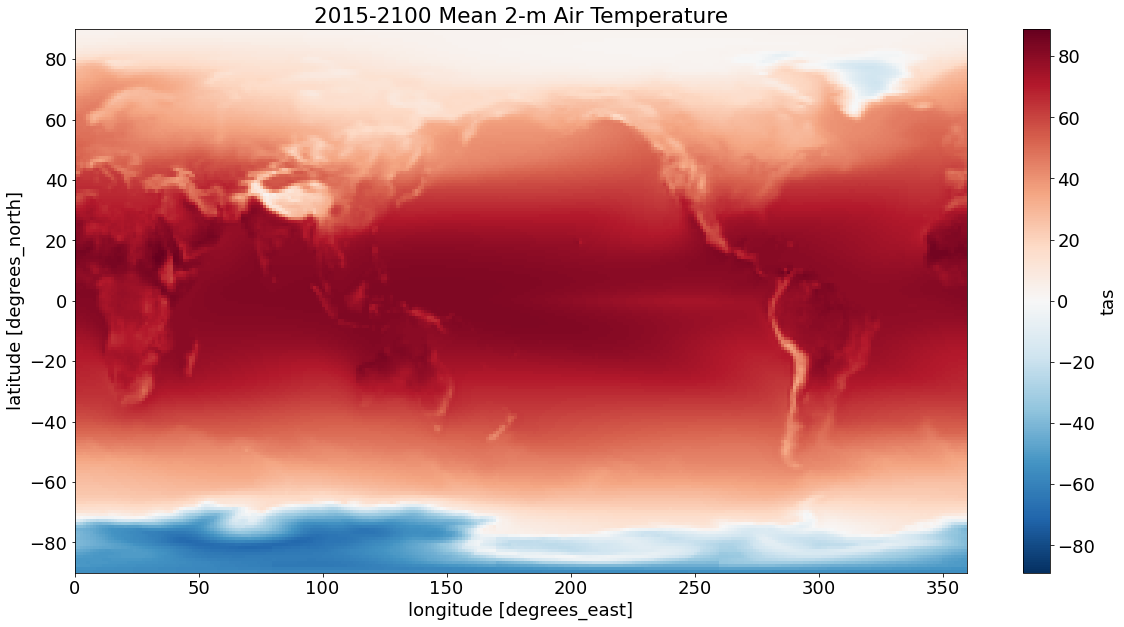

In [21]:
temp_mean.plot(figsize=(20, 10))
plt.title('2015-2100 Mean 2-m Air Temperature')

### Repeat for standard deviation

In [22]:
temp_std = ds['tas'].std(dim='time')

In [23]:
%time temp_std = temp_std.compute()

CPU times: user 50.7 ms, sys: 4.91 ms, total: 55.6 ms
Wall time: 8.5 s


Text(0.5, 1.0, '2015-2100 Standard Deviation 2-m Air Temperature')

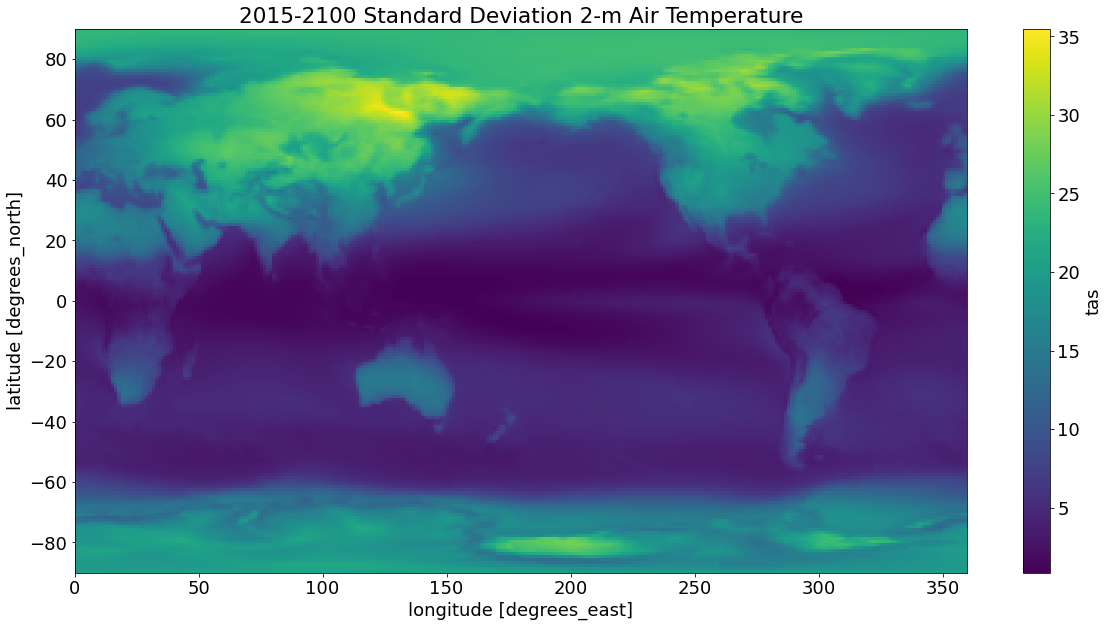

In [24]:
temp_std.plot(figsize=(20, 10))
plt.title('2015-2100 Standard Deviation 2-m Air Temperature')

## Plot temperature time series for points

In [25]:
# location coordinates
locs = [
    {'name': 'Santa Barbara', 'lon': -119.70, 'lat': 34.42},
    {'name': 'Colorado Springs', 'lon': -104.82, 'lat': 38.83},
    {'name': 'Honolulu', 'lon': -157.84, 'lat': 21.29},
    {'name': 'Seattle', 'lon': -122.33, 'lat': 47.61},
]

# convert westward longitudes to degrees east
for l in locs:
    if l['lon'] < 0:
        l['lon'] = 360 + l['lon']
locs

[{'name': 'Santa Barbara', 'lon': 240.3, 'lat': 34.42},
 {'name': 'Colorado Springs', 'lon': 255.18, 'lat': 38.83},
 {'name': 'Honolulu', 'lon': 202.16, 'lat': 21.29},
 {'name': 'Seattle', 'lon': 237.67000000000002, 'lat': 47.61}]

In [30]:
ds_locs = xr.Dataset()
air_temp_ds = ds

# interate through the locations and create a dataset
# containing the temperature values for each location
for l in locs:
    name = l['name']
    lon = l['lon']
    lat = l['lat']
    var_name = name

    ds2 = air_temp_ds.sel(lon=lon, lat=lat, method='nearest')

    lon_attr = '%s_lon' % name
    lat_attr = '%s_lat' % name

    ds2.attrs[lon_attr] = ds2.lon.values.tolist()
    ds2.attrs[lat_attr] = ds2.lat.values.tolist()
    ds2 = ds2.rename({'tas' : var_name}).drop(('lat', 'lon', 'height', 'lat_bnds', 'lon_bnds'))

    ds_locs = xr.merge([ds_locs, ds2], compat='override')

ds_locs.data_vars

Data variables:
    Santa Barbara     (time) float32 dask.array<chunksize=(421,), meta=np.ndarray>
    Colorado Springs  (time) float32 dask.array<chunksize=(421,), meta=np.ndarray>
    Honolulu          (time) float32 dask.array<chunksize=(421,), meta=np.ndarray>
    Seattle           (time) float32 dask.array<chunksize=(421,), meta=np.ndarray>

### Convert to dataframe

In [31]:
df_f = ds_locs.to_dataframe()
df_f.describe()

,Santa Barbara,Colorado Springs,Honolulu,Seattle
count,62780.000000,62780.000000,62780.000000,62780.000000
mean,61.857880,49.709137,75.883705,46.186661
std,11.264415,18.002907,3.517426,11.514710
min,30.185278,-3.966026,62.430756,-3.104340
25%,52.528065,35.121765,73.393410,37.788750
50%,60.398972,47.668564,75.938087,45.599756
75%,71.497169,65.013535,78.844604,55.601765
max,93.166054,89.571434,84.897247,77.280922


## Plot the entire time series of temperatures

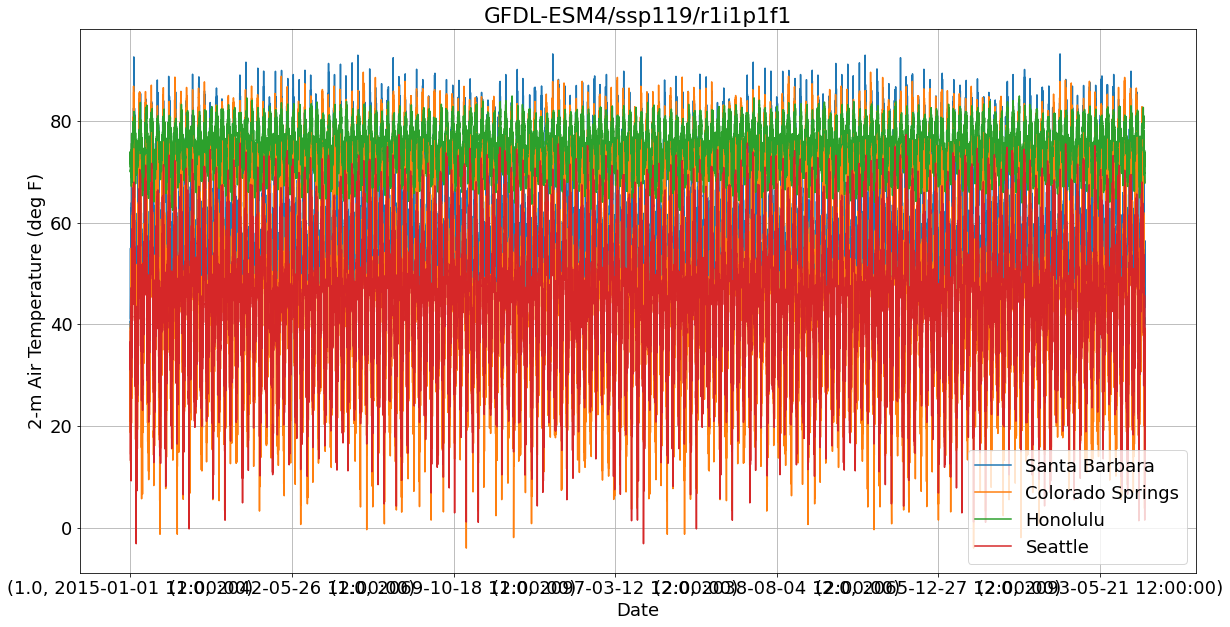

In [32]:
ax = df_f.plot(figsize=(20, 10), title="GFDL-ESM4/ssp119/r1i1p1f1", grid=1)
ax.set(xlabel='Date', ylabel='2-m Air Temperature (deg F)')
plt.show()

## Cluster scale down

When we are temporarily done with the cluster we can scale it down to save on costs

In [33]:
numWorkers=0
ecs.update_service(cluster=cluster, service='Dask-Worker', desiredCount=numWorkers)
ecs.get_waiter('services_stable').wait(cluster=cluster, services=['Dask-Worker'])